**1. Import the required libraries.**

In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pprint import pprint
from ultralytics import YOLO              # to load YOLO model (YOLOv8n (nano) specific for deployment in Jetson Nano)
from datasets import load_dataset
from tqdm import tqdm
from PIL import Image
from collections import Counter
from llama_cpp import Llama               # to load the TinyLlama Model (Used Quantized GGUF Model)

**2. Functions required to create logical attributes (Health Status, Leaves, Height, Dense, Isolated) based on bounding boxes identified by YOLO.**

In [2]:
def estimate_health(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
    green_ratio = cv2.countNonZero(green_mask) / (image.shape[0] * image.shape[1])
    return "Healthy" if green_ratio > 0.05 else "Unhealthy"  # Change the ratio threshold (i.e. 0.05) based on your requirements

def has_leaves(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
    green_pixels = cv2.countNonZero(green_mask)
    return green_pixels > 1000 # Change the green pixel threshold (i.e. 1000) based on your requirements

def categorize_height(box_height, image_height): # Change the ratios accordingly
    ratio = box_height / image_height
    if ratio < 0.2:
        return "Small"
    elif ratio < 0.5:
        return "Medium"
    else:
        return "Large"

def is_isolated(box, all_boxes, threshold=100):
    x1, y1, w1, h1 = box
    center_x1 = x1
    for other in all_boxes:
        if np.array_equal(box, other):
            continue
        x2, y2, w2, h2 = other
        center_x2 = x2
        if abs(center_x1 - center_x2) < threshold:
            return False
    return True

def visible_crown(image, box):
    x, y, w, h = [int(i) for i in box]
    crown_region = image[y:y+int(h*0.3), x:x+w]
    hsv = cv2.cvtColor(crown_region, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
    return cv2.countNonZero(green_mask) > 500

def canopy_coverage(image, box):
    x, y, w, h = [int(i) for i in box]
    region = image[y:y+h, x:x+w]
    hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
    green_ratio = cv2.countNonZero(green_mask) / (w * h)
    if green_ratio < 0.2:
        return "Sparse"
    elif green_ratio < 0.6:
        return "Partial"
    else:
        return "Full"

In [3]:
def classify_attributes(image, box, all_boxes, image_height):
    return {
        "HealthStatus": estimate_health(image),
        "HasLeaves": has_leaves(image),
        "TreeHeightCategory": categorize_height(box[3], image_height),
        "IsIsolated": is_isolated(box, all_boxes),
        "VisibleCrown": visible_crown(image, box),
        "CanopyCoverage": canopy_coverage(image, box)
    }

**3. Create JSON for Logical Attributes after running YOLO inference on a test drone aerial-view images.**

The inference JSON files are created based on the image file name. If the image name is test_image-1.jpg, then the output will be test_image-1.json.


image 1/1 /home/roysu/Tree Plantation/test_images/test_image-6.jpg: 384x640 9 clustered_treess, 35 single_trees, 75.5ms
Speed: 6.6ms preprocess, 75.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/roysu/Tree Plantation/test_images/test_image-9.jpg: 384x640 6 clustered_treess, 36 single_trees, 22.2ms
Speed: 3.1ms preprocess, 22.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/roysu/Tree Plantation/test_images/test_image-8.jpg: 384x640 7 clustered_treess, 40 single_trees, 22.4ms
Speed: 3.0ms preprocess, 22.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/roysu/Tree Plantation/test_images/test_image-7.jpg: 384x640 8 clustered_treess, 30 single_trees, 22.3ms
Speed: 4.1ms preprocess, 22.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
Image: test_image-6.jpg

Number of detections: 44


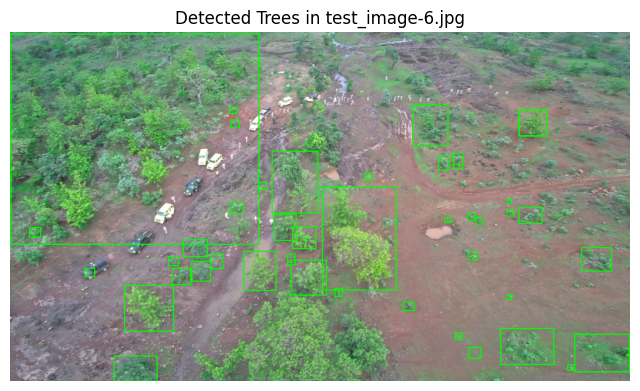

---------------------------------------------------------------------------------------------------------

Image: test_image-9.jpg

Number of detections: 42


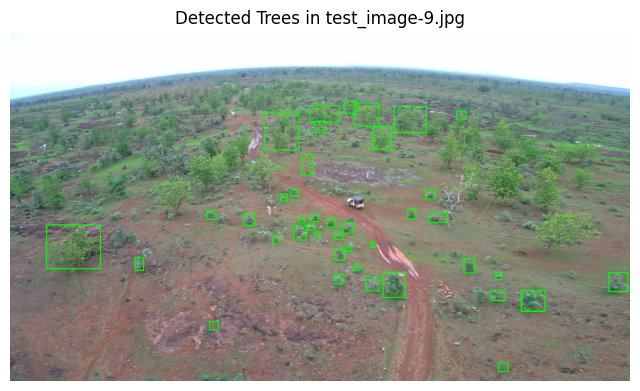

---------------------------------------------------------------------------------------------------------

Image: test_image-8.jpg

Number of detections: 47


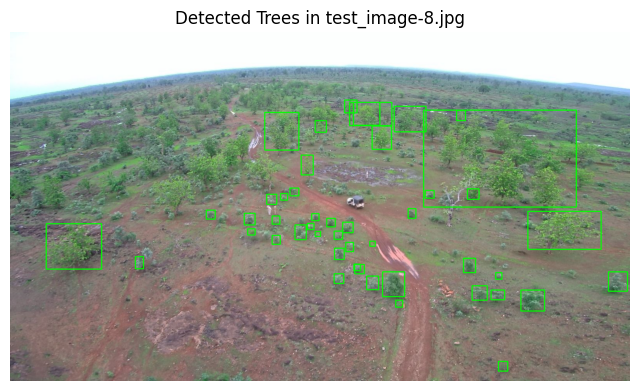

---------------------------------------------------------------------------------------------------------

Image: test_image-7.jpg

Number of detections: 38


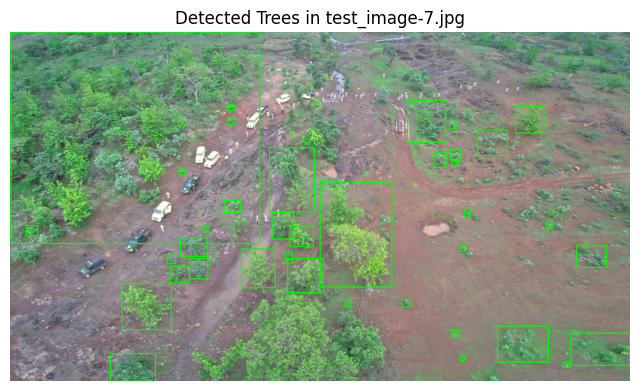

---------------------------------------------------------------------------------------------------------

Saved at: /home/roysu/Tree Plantation/test_inference/test_image-6.json
Saved at: /home/roysu/Tree Plantation/test_inference/test_image-9.json
Saved at: /home/roysu/Tree Plantation/test_inference/test_image-8.json
Saved at: /home/roysu/Tree Plantation/test_inference/test_image-7.json


In [7]:
# Load YOLO model (best.pt)
model = YOLO("/home/roysu/Tree Plantation/best.pt") # Change path accordingly based on where the model is located.

input_image_dir = "/home/roysu/Tree Plantation/test_images"
image_YOLO_set = []
image_file_set = []
test_image_set = []
image_set = []

# Load test images from input directory
for image_file in os.listdir(input_image_dir):
    if image_file.endswith("6.jpg") or image_file.endswith("7.jpg") or image_file.endswith("8.jpg") or image_file.endswith("9.jpg") or image_file.endswith(".png"):
        image_path = os.path.join(input_image_dir, image_file)
        if not os.path.exists(image_path):
            print(f"File does not exist: {image_path}")
        else:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
            else:
                results = model(image_path, conf=0.15)
                image_file_set.append(image_file)
                image_set.append(image)
                test_image_set.append(image)
                image_YOLO_set.append(results[0])

# Display test results after YOLO inference
for idx, output in enumerate(image_YOLO_set):
    print(f"Image: {image_file_set[idx]}")
    print()

    img = test_image_set[idx].copy()

    # Get bounding boxes
    boxes = output.boxes.xyxy.cpu().numpy()
    box_count = len(boxes)
    print(f"Number of detections: {box_count}")

    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Convert BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Detected Trees in {image_file_set[idx]}")
    plt.axis("off")
    plt.show()

    print("---------------------------------------------------------------------------------------------------------")
    print()

# Get Bounding Boxes, Class IDs (Single & Clustered Trees), and Confidence Scores

all_image_attributes = []

for index in range(len(image_YOLO_set)):
    boxes = image_YOLO_set[index].boxes.xywh.cpu().numpy()
    classes = image_YOLO_set[index].boxes.cls.cpu().numpy()
    confs = image_YOLO_set[index].boxes.conf.cpu().numpy()
    image_height = test_image_set[index].shape[0]

    all_attributes = []

    for box, cls, conf in zip(boxes, classes, confs):
        attr = classify_attributes(test_image_set[index], box, boxes, image_height)
        attr["bbox"] = box.tolist()
        attr["class"] = "Clustered Trees" if int(cls)==0 else "Single Tree"
        attr["confidence_score"] = float(conf)
        all_attributes.append(attr)

    all_image_attributes.append(all_attributes)

# Build the JSON-like dictionary and save it
output_dir = "/home/roysu/Tree Plantation/test_inference"

for index in range(len(image_file_set)):
    tree_data = {
        "image": image_file_set[index],
        "tree_attributes": all_image_attributes[index]
    }

    # Save JSON output annotations
    base_name = os.path.splitext(image_file_set[index])[0]
    json_filename = f"{base_name}.json"
    output_path = os.path.join(output_dir, json_filename)

    with open(output_path, "w") as f:
        json.dump(tree_data, f, indent=2)

    print(f"Saved at: {output_path}")

**4. Load JSON File and Create an Input Prompt for TinyLlama Quantized GGUF Version Model. You can check for the JSON File Name and Path in the previous cell output (the last phrase)**

In [11]:
# Load JSON Files
json_dir = output_dir
json_file_set = []
prompt_set = []

for json_file in os.listdir(json_dir):
    if json_file.endswith(".json"):
        json_file_path = os.path.join(json_dir, json_file)
    json_file_set.append(json_file)


    with open(json_file_path, "r") as f:
        data = json.load(f)

    # Extract Data from JSON (And Aggregate for All Trees in Image)
    image_name = data["image"]
    trees = data["tree_attributes"]

    total_trees = len(trees)
    total_confidence = 0.0
    total_area = 0.0
    clustered_trees = 0
    single_trees = 0
    uncertain_trees = 0

    health_counter = Counter()
    has_leaves_count = 0
    isolated_count = 0
    visible_crown_count = 0
    canopy_coverage_counter = Counter()
    height_category_counter = Counter()

    for t in trees:
        confidence = t["confidence_score"]
        total_confidence += confidence
        w, h = t["bbox"][2], t["bbox"][3]
        total_area += w * h

        if confidence < 0.15:
            uncertain_trees += 1

        if t.get("class", "").lower() == "clustered tree":
            clustered_trees += 1
        else:
            single_trees += 1

        # Logical Attributes Aggregation
        health_status = t.get("HealthStatus", "Unknown")
        health_counter[health_status] += 1

        if str(t.get("HasLeaves", "False")).lower() == "true":
            has_leaves_count += 1

        if str(t.get("IsIsolated", "False")).lower() == "true":
            isolated_count += 1

        if str(t.get("VisibleCrown", "False")).lower() == "true":
            visible_crown_count += 1

    canopy_coverage_string = t.get("CanopyCoverage", "Unknown").lower()
    canopy_coverage_counter[canopy_coverage_string] += 1

    height_category = t.get("TreeHeightCategory", "Unknown")
    height_category_counter[height_category] += 1

    # Calculate Average Confidence Scores and Bounding Box Areas
    avg_confidence = total_confidence / total_trees if total_trees else 0
    avg_bbox_area = total_area / total_trees if total_trees else 0

    # Generation of a General Input Prompt for Each Image

    prompt = f"""### Instruction:
    You are a forestry assistant analyzing this drone image with object detection and semantic attributes.

    ### Input:
    Image: {image_name}
    Total Trees: {total_trees}
    - Single: {single_trees}
    - Clustered: {clustered_trees}
    - Uncertain Detections (<0.5 confidence): {uncertain_trees}

    Detection Stats:
    - Avg Confidence: {avg_confidence:.2f}
    - Avg BBox Area: {avg_bbox_area:.2f}

    Tree Attributes Summary:
    - Health Statuses: {dict(health_counter)}
    - Trees with Leaves: {has_leaves_count}
    - Isolated Trees: {isolated_count}
    - Trees with Visible Crown: {visible_crown_count}
    - Canopy Coverage Types: {dict(canopy_coverage_counter)}
    - Tree Height Categories: {dict(height_category_counter)}

    ### Questions:
    1. Assess plantation health and density. Are trees healthy, dense, and well-distributed?
    2. What actions should be taken to improve plantation health?
    3. Are there signs of overcrowding, poor spacing, or deforested gaps?
    4. If there are any clustered trees detected, is their overall canopy coverage healthy?

    ### Response:
    """

    prompt_set.append(prompt)
    print(prompt)
    print()
    print("------------------------------------------------------------------------------------------------------")
    print()

### Instruction:
    You are a forestry assistant analyzing this drone image with object detection and semantic attributes.

    ### Input:
    Image: test_image-6.jpg
    Total Trees: 44
    - Single: 44
    - Clustered: 0
    - Uncertain Detections (<0.5 confidence): 0

    Detection Stats:
    - Avg Confidence: 0.29
    - Avg BBox Area: 12156.99

    Tree Attributes Summary:
    - Health Statuses: {'Healthy': 44}
    - Trees with Leaves: 44
    - Isolated Trees: 2
    - Trees with Visible Crown: 14
    - Canopy Coverage Types: {'sparse': 1}
    - Tree Height Categories: {'Small': 1}

    ### Questions:
    1. Assess plantation health and density. Are trees healthy, dense, and well-distributed?
    2. What actions should be taken to improve plantation health?
    3. Are there signs of overcrowding, poor spacing, or deforested gaps?
    4. If there are any clustered trees detected, is their overall canopy coverage healthy?

    ### Response:
    

-------------------------------------

In [9]:
# Use Quantized TinyLlama Model, with input context tokens to be 768 (will work with Jetson Nano with enough memory/RAM)
llm = Llama(model_path="/home/roysu/Tree Plantation/TinyLlama-1.1B-Chat-v1.0.gguf", n_ctx = 768, verbose = False)

for index in range(len(prompt_set)):

    prompt = prompt_set[index]
    # Temperature is lesser to give deterministic outputs, with maximum tokens to be generated as 768
    output = llm(prompt, max_tokens=768, temperature=0.5, top_p=0.9, repeat_penalty=1.1)

    # Display Prompt and Output
    print(f"Output for {json_file_set[index]}:")
    print(output['choices'][0]['text'])
    print()
    print("------------------------------------------------------------------------------------------------------")
    print()

llama_context: n_ctx_per_seq (768) < n_ctx_train (2048) -- the full capacity of the model will not be utilized


Output for test_image-6.json:
1. A healthy plantation should have a balance of trees with healthy leaves, healthy crown coverage, and well-distributed trees.
    2. The actions to improve plantation health include pruning or removing overcrooked trees, reducing spacing between trees, and improving the canopy coverage by removing isolated trees.
    3. No signs of overcrowding were found in this image.
    4. Clustered trees detected in this image have overall canopy coverage that is healthy based on visual inspection.

------------------------------------------------------------------------------------------------------

Output for test_image-9.json:
1. Plantation Health:
    2. Trees healthy: No evidence of overcrooding, poor spacing, or deforesed gap. Canopy coverage is adequate.
    3. Trees with dense canopy: Overall canopy coverage is good.
    4. Clustered trees detected: Yes, there are clusters of trees in the image that indicate poor spacing and deforesed gaps. This indicates a